## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [2]:
import requests
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=365)

## **Data Collection**

In [3]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [4]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    if start > end:
        raise ValueError("start date must be <= end date")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [5]:
try:
    weather_df = fetch_weather_timeseries("Dubai")
    display(weather_df.head())
    display(weather_df.tail(3))
    print(f"Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
except Exception as exc:
    print(f"Fetch failed: {exc}")


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2024-12-20,25.4,14.2,19.5,0.0
2024-12-21,24.9,12.7,18.8,0.0
2024-12-22,25.0,14.1,19.2,0.0
2024-12-23,24.3,14.6,19.6,0.0
2024-12-24,26.7,14.0,20.2,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-18,24.7,19.7,22.0,8.3
2025-12-19,20.7,14.9,18.8,35.5
2025-12-20,20.1,12.7,15.4,0.1


Fetched 366 days spanning 2024-12-20 to 2025-12-20


## **Data Exploration and Cleaning**

In [6]:
# Basic structure
print(weather_df.info())
print(weather_df.describe())

# Missing values check
print("\nMissing values per column:")
print(weather_df.isna().sum())

# Quick correlation snapshot
corr = weather_df.corr()
print("\nCorrelation matrix:")
display(corr)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-12-20 to 2025-12-20
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_max_c   366 non-null    float64
 1   temp_min_c   366 non-null    float64
 2   temp_mean_c  366 non-null    float64
 3   precip_mm    366 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB
None
       temp_max_c  temp_min_c  temp_mean_c   precip_mm
count  366.000000  366.000000   366.000000  366.000000
mean    35.072404   22.743989    28.319672    0.144809
std      7.270517    5.949661     6.213472    1.916307
min     20.100000   10.200000    15.400000    0.000000
25%     28.900000   17.625000    22.825000    0.000000
50%     36.000000   23.550000    29.150000    0.000000
75%     41.075000   27.700000    33.600000    0.000000
max     47.900000   33.300000    39.100000   35.500000

Missing values per column:
temp_max_c     0
temp_min_c     0
temp_mean_c    0
preci

,temp_max_c,temp_min_c,temp_mean_c,precip_mm
temp_max_c,1.000000,0.900894,0.973082,-0.127992
temp_min_c,0.900894,1.000000,0.972158,-0.083141
temp_mean_c,0.973082,0.972158,1.000000,-0.100780
precip_mm,-0.127992,-0.083141,-0.100780,1.000000


<Figure size 640x480 with 0 Axes>

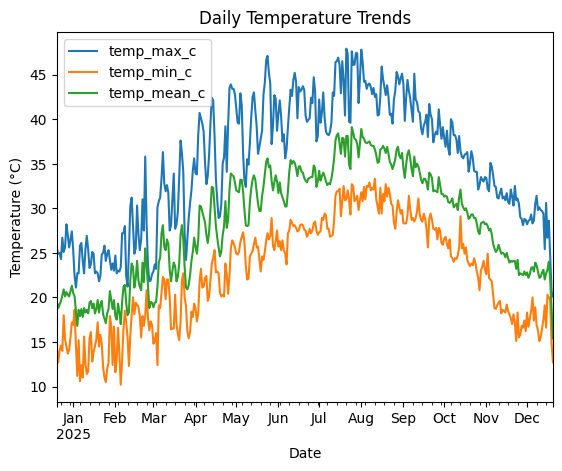

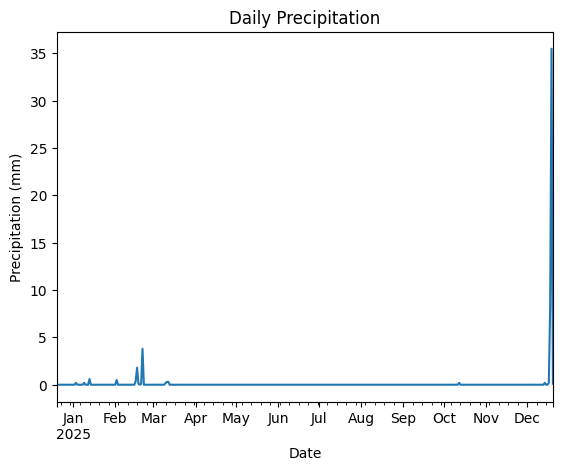

In [7]:
plt.figure()
weather_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].plot()
plt.title("Daily Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure()
weather_df["precip_mm"].plot()
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

In [8]:
df = weather_df.copy()

df["day_of_year"] = df.index.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

<Figure size 640x480 with 0 Axes>

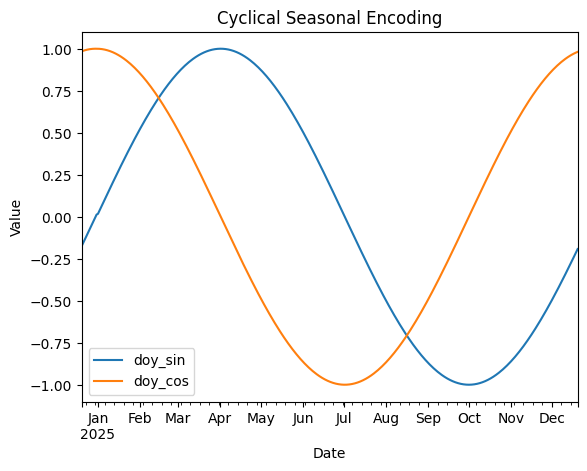

In [9]:
plt.figure()
df[["doy_sin", "doy_cos"]].plot()
plt.title("Cyclical Seasonal Encoding")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

### **Dataset Split**

In [10]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Sort by time (important safeguard)
df = df.sort_index()

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df)

train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)


train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

assert train_df.index.max() < val_df.index.min()
assert val_df.index.max() < test_df.index.min()

## **Univariate AutoRegressive (AR(p)) Model**

In [12]:
target_col = "temp_max_c"

train_series = train_df[target_col].dropna()
val_series = val_df[target_col].dropna()
test_series = test_df[target_col].dropna()

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

max_lag = 30
lag_errors = {}

for lag in range(1, max_lag + 1):
    model = AutoReg(train_series, lags=lag, old_names=False)
    model_fit = model.fit()

    preds = model_fit.predict(
        start=val_series.index[0],
        end=val_series.index[-1],
        dynamic=False
    )

    preds = preds.reindex(val_series.index)
    error = mean_absolute_error(val_series, preds)
    lag_errors[lag] = error

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/

In [13]:
best_lag = min(lag_errors, key=lag_errors.get)
best_lag

# train the model
full_train = pd.concat([train_series, val_series])

final_model = AutoReg(full_train, lags=best_lag, old_names=False)
final_model_fit = final_model.fit()

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
test_preds = final_model_fit.predict(
    start=test_series.index[0],
    end=test_series.index[-1],
    dynamic=False
)

test_preds = test_preds.reindex(test_series.index)

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(test_series, test_preds)
rmse = np.sqrt(mean_squared_error(test_series, test_preds))

mae, rmse

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


(5.518807558208391, np.float64(6.401461880975941))

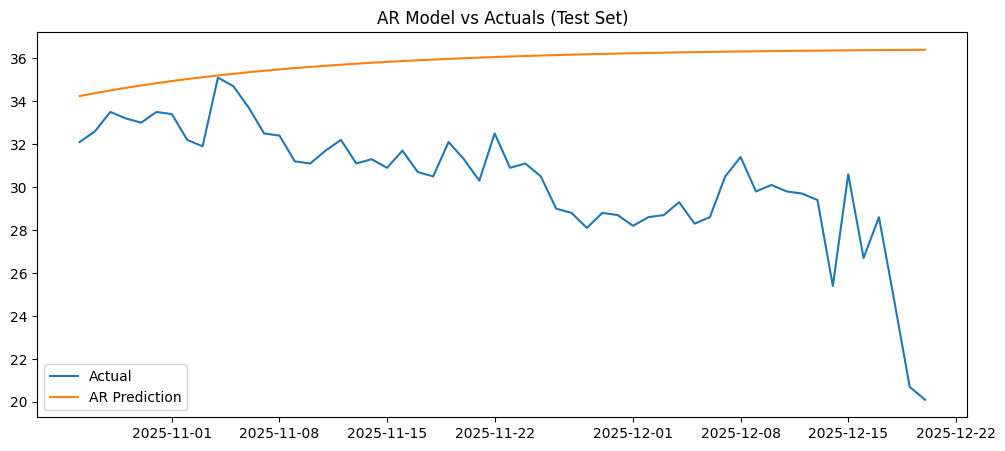

In [15]:
naive_preds = test_series.shift(1)
naive_mae = mean_absolute_error(test_series[1:], naive_preds[1:])
naive_mae

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test_series, label="Actual")
plt.plot(test_preds, label="AR Prediction")
plt.legend()
plt.title("AR Model vs Actuals (Test Set)")
plt.show()


In [17]:
error_df = pd.DataFrame({
    "actual": test_series,
    "prediction": test_preds
})

error_df["delta"] = error_df["prediction"] - error_df["actual"]
error_df["abs_delta"] = error_df["delta"].abs()
error_df["squared_delta"] = error_df["delta"] ** 2

error_stats = {
    "Mean Error (Bias)": error_df["delta"].mean(),
    "Mean Absolute Error": error_df["abs_delta"].mean(),
    "Median Absolute Error": error_df["abs_delta"].median(),
    "Max Absolute Error": error_df["abs_delta"].max(),
    "Error Std Dev": error_df["delta"].std()
}

pd.Series(error_stats)

Mean Error (Bias)         5.518808
Mean Absolute Error       5.518808
Median Absolute Error     5.193596
Max Absolute Error       16.294757
Error Std Dev             3.273038
dtype: float64

In [18]:
baseline_delta = test_series.shift(1) - test_series
baseline_mae = baseline_delta.abs().mean()

ar_improvement = baseline_mae - error_df["abs_delta"].mean()
ar_improvement

np.float64(-4.446080285481118)

In [19]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value, *_ = adfuller(train_series)
p_value

np.float64(0.7383123616173535)

### **AR on Differenced Data with Cyclical Regressors**

In [20]:
target_col = "temp_max_c"

train_y = train_df[target_col].dropna()
val_y = val_df[target_col].dropna()
test_y = test_df[target_col].dropna()

# First difference
train_diff = train_y.diff().dropna()
val_diff = val_y.diff().dropna()
test_diff = test_y.diff().dropna()

from statsmodels.tsa.stattools import adfuller

adf_p_value = adfuller(train_diff)[1]
adf_p_value

np.float64(1.396319173960938e-10)

In [ ]:
def add_cyclical_features(df):
    day_of_year = df.index.dayofyear
    df = df.copy()
    df["sin_doy"] = np.sin(2 * np.pi * day_of_year / 365)
    df["cos_doy"] = np.cos(2 * np.pi * day_of_year / 365)
    return df

train_exog = add_cyclical_features(train_df)[["sin_doy", "cos_doy"]].loc[train_diff.index]
val_exog = add_cyclical_features(val_df)[["sin_doy", "cos_doy"]].loc[val_diff.index]
test_exog = add_cyclical_features(test_df)[["sin_doy", "cos_doy"]].loc[test_diff.index]

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

max_lag = 30
lag_errors = {}

common_val_index = val_diff.index.intersection(val_exog.index)
val_diff_aligned = val_diff.loc[common_val_index]
val_exog_aligned = val_exog.loc[common_val_index]

for lag in range(1, max_lag + 1):
    model = AutoReg(
        train_diff,
        lags=lag,
        exog=train_exog,
        old_names=False
    )
    model_fit = model.fit()

    preds = model_fit.forecast(
        steps=len(val_diff_aligned),
        exog=val_exog_aligned
    )

    preds.index = val_diff_aligned.index
    lag_errors[lag] = mean_absolute_error(val_diff_aligned, preds)


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/

In [27]:
best_lag = min(lag_errors, key=lag_errors.get)
best_lag

7

In [28]:
# train final model (train + validation)

full_diff = pd.concat([train_diff, val_diff])
full_exog = pd.concat([train_exog, val_exog])

final_model = AutoReg(
    full_diff,
    lags=best_lag,
    exog=full_exog,
    old_names=False
)

final_fit = final_model.fit()

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
# Use integer positions for prediction (not timestamps)
n_full = len(full_diff)
start = n_full
end = start + len(test_diff) - 1

diff_preds = final_fit.predict(
    start=start,
    end=end,
    exog_oos=test_exog,
    dynamic=False
)

# Create a Series with the correct index from test_diff
# diff_preds comes back with integer index, we need to align with test_diff
diff_preds = pd.Series(diff_preds.values, index=test_diff.index)

# Invert differencing: need the last actual value BEFORE differencing
# This is the last value from the combined train+val series
last_actual = pd.concat([train_y, val_y]).iloc[-1]

# Reconstruct level predictions by cumulative sum
# test_diff corresponds to test_y[1:] - test_y[:-1], so predictions align with test_y[1:]
level_preds = last_actual + diff_preds.cumsum()

# Align with test_y[1:] since differencing dropped the first observation
# This gives us predictions for all test_y except the first value
level_preds.index = test_y.index[1:]

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [ ]:
last_train_value = full_diff.index.min()
last_actual = pd.concat([train_y, val_y]).iloc[-1]

level_preds = last_actual + diff_preds.cumsum()

In [ ]:
error_df = pd.DataFrame({
    "actual": test_y.loc[level_preds.index],
    "prediction": level_preds
})

error_df["delta"] = error_df["prediction"] - error_df["actual"]
error_df["abs_delta"] = error_df["delta"].abs()

mae = error_df["abs_delta"].mean()
rmse = np.sqrt((error_df["delta"] ** 2).mean())

mae, rmse

(np.float64(1.4192582575233281), np.float64(2.1830966487807824))

In [ ]:
naive_mae = test_y.diff().abs().mean()
mae, naive_mae

(np.float64(1.4192582575233281), np.float64(1.0727272727272732))